# Summary

Preprocessing every dataset:
- Handling null value with 0 for more than 40% except some of feature are dropped with null value > 70%. The rest (under 20%) are filled with median and mode
- Handled duplicated data
- Feature engineering in every dataset
- Merging all dataset without categorical data (because other datasets are aggregated)

Preprocessing the merger dataset:
- Handling null value with the same method
- No duplicated data
- split train test in df_train dataset with test_size = 0.2
- Handling outliers using feature transformation yeo - johnson, not using iqr or z-score
- Handling class imbalance using SMOTE because the class is imbalance extreme

Modelling Result:
1. Logistic Regression (tuned Ridge):
    - ROC AUC train: 0.77
    - ROC UAC validation: 0.74
    - Times Taken: 1m 29.7s

2. Decision Tree:
    - ROC AUC train: 1.0
    - ROC UAC validation: 0.50
    - Time Taken: 1m 31.1s

3. Random Forest (tuned):
    - ROC AUC train: 0.99
    - ROC UAC validation: 0.69
    - Time Taken: 97m 36.7s

4. AdaBoost (tuned):
    - ROC AUC train: 0.95
    - ROC UAC validation: 0.63
    - Time Taken: 72m 27.5s

5. XGBoost (tuned):
    - ROC AUC train: 0.96
    - ROC UAC validation: 0.69
    - Time Taken: 1m 56.9s

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os
import statsmodels.api as sm

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import roc_curve,auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import fbeta_score
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import boxcox, yeojohnson
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Function untuk mengecek persentase null value

def check_null_percentage(df):
    # Hitung total rows
    total_rows = len(df)

    # Hitung null values dan persentasenya
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / total_rows * 100).round(2)

    # Buat dataframe hasil
    null_df = pd.DataFrame({
        'Total_Null': null_counts,
        'Null_Percentage': null_percentage
    })

    # Sorting berdasarkan persentase null terbesar
    null_df = null_df.sort_values('Null_Percentage', ascending=False)

    # Filter hanya kolom yang memiliki null values
    null_df = null_df[null_df['Total_Null'] > 0]

    return null_df



# Import Dataset

In [3]:
df_train = pd.read_csv('new_train.csv.gz', compression='gzip')
df_test = pd.read_csv('new_test.csv.gz', compression='gzip')

In [4]:
print('df_train dimension:', df_train.shape)
print('df_test dimension: ', df_test.shape)

df_train dimension: (307511, 342)
df_test dimension:  (48744, 341)


# Preprocessing

In [5]:
df_train.drop(columns=['SK_ID_CURR', 'CCB_SK_ID_CURR_'], axis = 1, inplace=True)
df_test.drop(columns=['SK_ID_CURR', 'CCB_SK_ID_CURR_'], axis = 1, inplace=True)

In [6]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 339 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    FLAG_OWN_CAR                                int64  
 1    FLAG_OWN_REALTY                             int64  
 2    CNT_CHILDREN                                int64  
 3    AMT_INCOME_TOTAL                            float64
 4    AMT_CREDIT                                  float64
 5    AMT_ANNUITY                                 float64
 6    AMT_GOODS_PRICE                             float64
 7    NAME_EDUCATION_TYPE                         int64  
 8    REGION_POPULATION_RELATIVE                  float64
 9    DAYS_BIRTH                                  int64  
 10   DAYS_EMPLOYED                               int64  
 11   DAYS_REGISTRATION                           float64
 12   DAYS_ID_PUBLISH                             int64  
 13   OWN_CAR_AGE   

In [7]:
# # Check null value (df_train) after handling null value
null_analysis = check_null_percentage(df_train)
print("Total rows in dataset:", len(df_train))
print("\nNull Value Analysis:")
print(null_analysis)

Total rows in dataset: 307511

Null Value Analysis:
                                            Total_Null  Null_Percentage
CCB_DRAWINGS_OTHER_PERCENTAGE_MAX               250458            81.45
CCB_DRAWINGS_OTHER_PERCENTAGE_MIN               250458            81.45
CCB_DRAWINGS_OTHER_PERCENTAGE_MEAN              250458            81.45
CCB_AVG_DRAWING_MIN                             250457            81.45
CCB_DRAWINGS_ATM_PERCENTAGE_MAX                 250458            81.45
CCB_DRAWINGS_ATM_PERCENTAGE_MEAN                250458            81.45
CCB_DRAWINGS_POS_PERCENTAGE_MIN                 250458            81.45
CCB_DRAWINGS_ATM_PERCENTAGE_MIN                 250458            81.45
CCB_DRAWINGS_POS_PERCENTAGE_MAX                 250458            81.45
CCB_AVG_DRAWING_MEAN                            250458            81.45
CCB_AVG_DRAWING_MAX                             250457            81.45
CCB_DRAWINGS_POS_PERCENTAGE_MEAN                250458            81.45
CCB_LIMIT_RA

In [8]:
def handling_na(data):

    total_rows = len(data)
    null_counts = data.isnull().sum()
    null_percentage = (null_counts / total_rows * 100).round(2)

    for col in data:
        if null_percentage[col] > 40:
            data[col] = data[col].fillna(0)
        else:
            data[col] = data[col].fillna(data[col].median())
    
    return data


In [9]:
train_clean = handling_na(df_train)
test_clean = handling_na(df_test)

In [10]:
print('Total data duplicated pada Train: ', train_clean.duplicated().sum())
print('Total data duplicated pada Test: ', test_clean.duplicated().sum())

Total data duplicated pada Train:  0
Total data duplicated pada Test:  0


## Split Train Test

In [11]:
X = train_clean.drop(columns=['TARGET'], axis = 1)
y = train_clean['TARGET']
X_test = test_clean

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)

print("X_train dimension: ", X_train.shape)
print("y_train dimension: ", y_train.shape)
print("X_val dimension: ", X_val.shape)
print("y_val dimension: ", y_val.shape)
print("X_test dimension: ", X_test.shape)

X_train dimension:  (246008, 339)
y_train dimension:  (246008,)
X_val dimension:  (61503, 339)
y_val dimension:  (61503,)
X_test dimension:  (48744, 339)


## Handling Outliers and Feature Transformation

In [13]:
 def plot_boxplots(df, features):
     
    plt.figure(figsize=(15, len(features) * 5))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)  
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')
        plt.xlabel(feature)

    plt.tight_layout() 
    plt.show()

In [14]:
X_train.describe(include='all')

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DEBT_TO_INCOME,ANNUITY_TO_INCOME,AGE,TENURE,FAM_ADULT_MEMBERS,CHILDREN_PER_FAM_MEMBERS,NUM_DOCUMENTS,EXT_SOURCE_MEAN,BUR_SK_ID_BUREAU_COUNT,BUR_DAYS_CREDIT_MIN,BUR_DAYS_CREDIT_MAX,BUR_DAYS_CREDIT_MEAN,BUR_DAYS_CREDIT_ENDDATE_MIN,BUR_DAYS_CREDIT_ENDDATE_MAX,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_DAYS_ENDDATE_FACT_MIN,BUR_DAYS_ENDDATE_FACT_MAX,BUR_DAYS_ENDDATE_FACT_MEAN,BUR_DAYS_CREDIT_UPDATE_MIN,BUR_DAYS_CREDIT_UPDATE_MAX,BUR_DAYS_CREDIT_UPDATE_MEAN,BUR_DAYS_DURATION_CREDIT_MIN,BUR_DAYS_DURATION_CREDIT_MAX,BUR_DAYS_DURATION_CREDIT_MEAN,BUR_CREDIT_DAY_OVERDUE_MAX,BUR_CREDIT_DAY_OVERDUE_MEAN,BUR_CREDIT_DAY_OVERDUE_SUM,BUR_AMT_CREDIT_MAX_OVERDUE_MAX,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_AMT_CREDIT_SUM_MAX,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_SUM,BUR_AMT_CREDIT_SUM_DEBT_MAX,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_DEBT_SUM,BUR_AMT_CREDIT_SUM_LIMIT_MAX,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_SUM,BUR_AMT_CREDIT_SUM_OVERDUE_MAX,BUR_AMT_CREDIT_SUM_OVERDUE_MEAN,BUR_AMT_CREDIT_SUM_OVERDUE_SUM,BUR_AMT_ANNUITY_MAX,BUR_AMT_ANNUITY_MEAN,BUR_AMT_ANNUITY_SUM,BUR_CNT_CREDIT_PROLONG_MAX,BUR_CNT_CREDIT_PROLONG_SUM,BUR_MONTHS_BALANCE_MIN,BUR_MONTHS_BALANCE_MAX,BUR_MONTHS_BALANCE_MEAN,INST_NUM_INSTALMENT_VERSION_NUNIQUE,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_NUMBER_MIN,INST_NUM_INSTALMENT_NUMBER_MAX,INST_NUM_INSTALMENT_NUMBER_MEAN,INST_NUM_INSTALMENT_NUMBER_SUM,INST_DAYS_LATE_MEAN,INST_DAYS_LATE_MAX,INST_DAYS_LATE_SUM,INST_DAYS_LATE_COUNT,INST_FLAG_LATE_PAYMENT_MEAN,INST_FLAG_LATE_PAYMENT_SUM,INST_PAYMENT_RATIO_MEAN,INST_PAYMENT_RATIO_MIN,INST_PAYMENT_DIFF_MEAN,INST_PAYMENT_DIFF_MAX,INST_PAYMENT_DIFF_SUM,INST_FLAG_UNDERPAYMENT_MEAN,INST_FLAG_UNDERPAYMENT_SUM,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_MAX,INST_AMT_INSTALMENT_SUM,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_SUM,INST_MONTH_INSTALMENT_MIN,INST_MONTH_INSTALMENT_MAX,INST_MONTH_ENTRY_PAYMENT_MIN,INST_MONTH_ENTRY_PAYMENT_MAX,INST_YEAR_INSTALLMENT_MIN,INST_YEAR_INSTALLMENT_MAX,INST_YEAR_ENTRY_PAYMENT_MIN,INST_YEAR_ENTRY_PAYMENT_MAX,CCB_MONTHS_BALANCE_COUNT,CCB_AMT_BALANCE_MIN,CCB_AMT_BALANCE_MAX,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_SUM,CCB_AMT_CREDIT_LIMIT_ACTUAL_MIN,CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX,CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM,CCB_AMT_DRAWINGS_ATM_CURRENT_MIN,CCB_AMT_DRAWINGS_ATM_CURRENT_MAX,CCB_AMT_DRAWINGS_ATM_CURRENT_MEAN,CCB_AMT_DRAWINGS_ATM_CURRENT_SUM,CCB_AMT_DRAWINGS_CURRENT_MIN,CCB_AMT_DRAWINGS_CURRENT_MAX,CCB_AMT_DRAWINGS_CURRENT_MEAN,CCB_AMT_DRAWINGS_CURRENT_SUM,CCB_

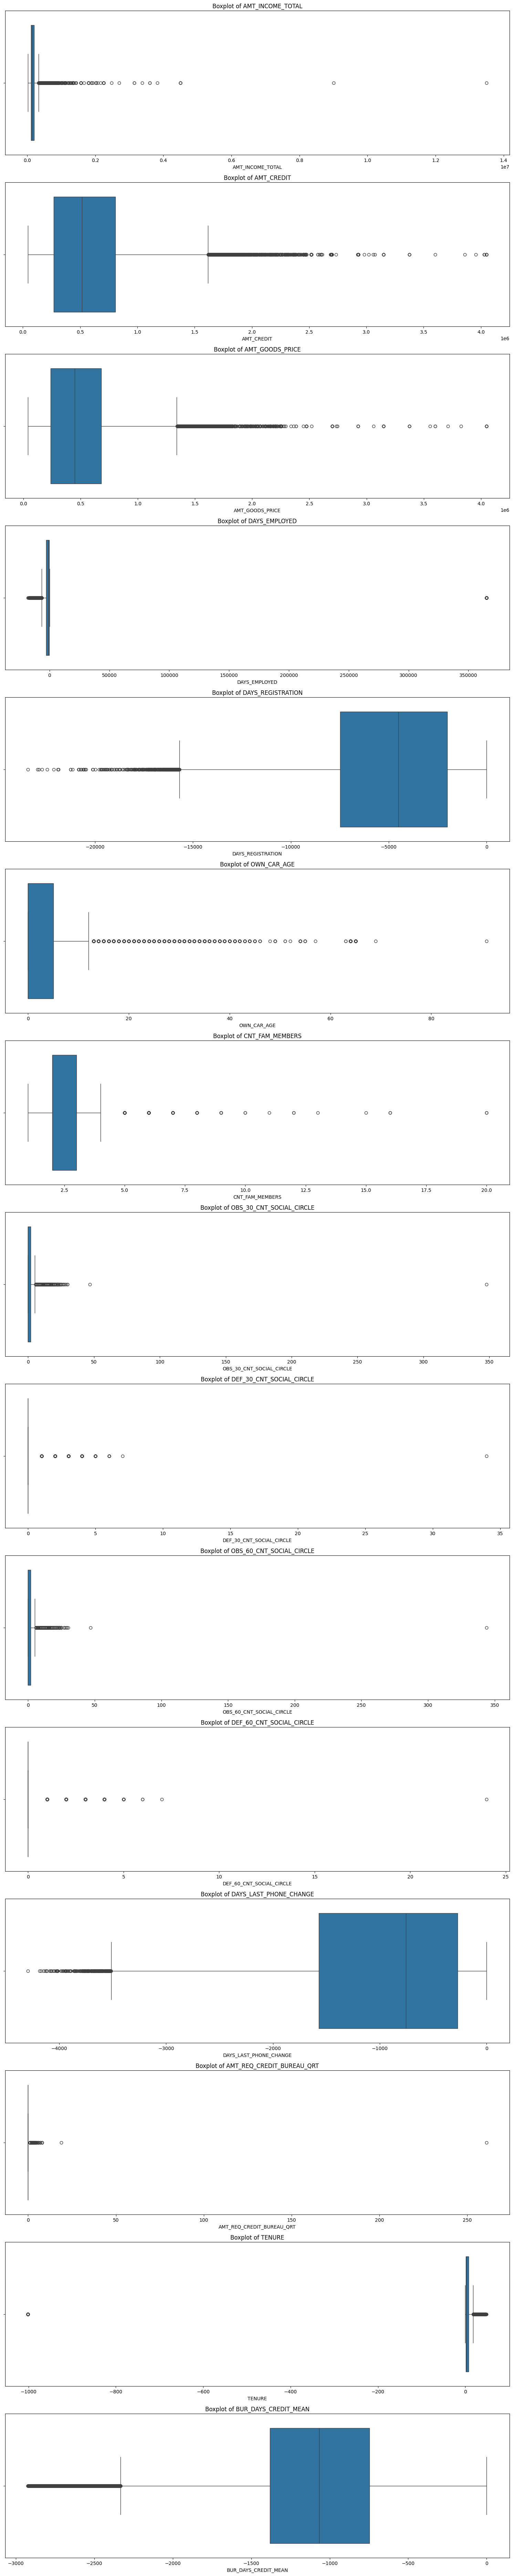

In [15]:
features_to_check = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
                     'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                     'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'TENURE', 'BUR_DAYS_CREDIT_MEAN'] 
plot_boxplots(X_train, features_to_check)

In [16]:
from sklearn.preprocessing import PowerTransformer
def apply_yeo_johnson(data):
    # Ada data infinite
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data.dropna(inplace=True)
    data.fillna(0, inplace=True)

    transformer = PowerTransformer(method='yeo-johnson')


    # Fit and transform the data
    transformed_features = transformer.fit_transform(data)
    
    # Create a DataFrame from the transformed features
    transformed_df = pd.DataFrame(transformed_features, columns=data.columns, index=data.index)
    
    return transformed_df

X_train_transformed = apply_yeo_johnson(X_train)

In [17]:
X_val_transformed = apply_yeo_johnson(X_val)

In [18]:
X_test_transformed = apply_yeo_johnson(X_test)

# Pre-Modelling

In [19]:
print("X_train dimension: ", X_train_transformed.shape)
print("y_train dimension: ", y_train.shape)
print("X_val dimension: ", X_val_transformed.shape)
print("y_val dimension: ", y_val.shape)
print("X_test dimension: ", X_test_transformed.shape)

X_train dimension:  (246008, 339)
y_train dimension:  (246008,)
X_val dimension:  (61503, 339)
y_val dimension:  (61503,)
X_test dimension:  (48744, 339)


In [20]:
y_train.value_counts()

TARGET
0    226132
1     19876
Name: count, dtype: int64

In [21]:
print("percentase kelas 0:", 49007/(49007+4732)*100)
print("percentase kelas 1:", 4732/(49007+4732)*100)

percentase kelas 0: 91.1944770092484
percentase kelas 1: 8.805522990751594


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_transformed), columns=X_train_transformed.columns)
X_val_scaled = pd.DataFrame(scaler.fit_transform(X_val_transformed), columns=X_val_transformed.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_transformed), columns=X_test_transformed.columns)

In [23]:
# Oversampling
from imblearn import over_sampling
X_train_over, y_train_over = over_sampling.SMOTE(sampling_strategy=1).fit_resample(X_train_scaled, y_train)

In [24]:
print("X_train dimension: ", X_train_over.shape)
print("y_train dimension: ", y_train_over.shape)
print("X_val dimension: ", X_val_scaled.shape)
print("y_val dimension: ", y_val.shape)
print("X_test dimension: ", X_test_transformed.shape)

X_train dimension:  (452264, 339)
y_train dimension:  (452264,)
X_val dimension:  (61503, 339)
y_val dimension:  (61503,)
X_test dimension:  (48744, 339)


In [25]:
y_train_over.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

# Modelling

In [26]:
# Untuk evaluasi model 

def model_evaluation(y_true, y_pred, y_pred_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2.0)
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    
    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2, auc]],
                       columns=["Model", "Accuracy", "Precision", "Recall",
                                "F1 Score", "F2 Score", "roc_auc_score"])
    return results

In [27]:
# Untuk cek overfitting vs underfitting atau best fit
def check_model_fit(classifier, X_train, X_val, y_train, y_val, model_name="Model"):
    """
    Membandingkan performa model pada data training dan validation
    untuk mendeteksi overfitting/underfitting
    """
    # Prediksi pada data training
    y_train_pred = classifier.predict(X_train)
    y_train_pred_proba = classifier.predict_proba(X_train)
    
    # Prediksi pada data validation
    y_val_pred = classifier.predict(X_val)
    y_val_pred_proba = classifier.predict_proba(X_val)
    
    # Metrics untuk training
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2.0)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_proba[:, 1])

    # Metrics untuk validation
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_f2 = fbeta_score(y_val, y_val_pred, beta=2.0)
    val_roc_auc = roc_auc_score(y_val, y_val_pred_proba[:, 1])
    

    # Membuat DataFrame perbandingan
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'ROC AUC'],
        'Training': [train_accuracy, train_precision, train_recall, train_f1, train_f2, train_roc_auc],
        'Validation': [val_accuracy, val_precision, val_recall, val_f1, val_f2, val_roc_auc],
        'Difference': [train_accuracy - val_accuracy, 
                      train_precision - val_precision,
                      train_recall - val_recall,
                      train_f1 - val_f1,
                      train_f2 - val_f2,
                      train_roc_auc - val_roc_auc]
    })
    
    print(f"\nModel Fit Analysis for {model_name}:")
    print(comparison.round(4))
    
    # Analisis overfitting/underfitting
    avg_diff = comparison['Difference'].mean()
    
    print("\nAnalisis:")
    if (train_roc_auc - val_roc_auc) > 0.01:  # Threshold bisa disesuaikan
        print("⚠️ Model menunjukkan tanda OVERFITTING")
        print(f"    selisih metrics training-validation: {(train_roc_auc - val_roc_auc):.4f}")
        print("   - Model terlalu 'menghapal' data training")
        print("   - Performa di validation jauh lebih rendah")
    elif (train_roc_auc - val_roc_auc) < 0.01:  # Threshold bisa disesuaikan
        print("⚠️ Model menunjukkan tanda UNDERFITTING")
        print(f"   ROC-AUC training: {train_roc_auc:.4f}")
        print("   - Model terlalu simpel")
        print("   - Performa rendah bahkan di data training")
    else:
        print("✅ Model memiliki fit yang baik")
        print(f"   Rata-rata selisih metrics: {(train_roc_auc - val_roc_auc):.4f}")
        print("   - Performa seimbang antara training dan validation")



In [28]:
# Evaluasi performa final model
def evaluate_final_model(model, X_train, X_val, y_train, y_val):
    # Training predictions
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, train_pred_proba)
    
    # Validation predictions
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_roc_auc = roc_auc_score(y_val, val_pred_proba)
    
    print("\nFinal Model Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Validation ROC-AUC: {val_roc_auc:.4f}")
    print(f"Difference: {train_roc_auc - val_roc_auc:.4f}")
    
    return train_roc_auc, val_roc_auc

# Logistic regression

In [30]:
classifier_logreg = LogisticRegression()
classifier_logreg.fit(X_train_over, y_train_over)
y_pred = classifier_logreg.predict(X_val_scaled)
y_pred_proba = classifier_logreg.predict_proba(X_val_scaled)

# Evaluasi
results_logreg = model_evaluation(y_val, y_pred, y_pred_proba, "Logistic Regression")
results_logreg

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Logistic Regression,0.697218,0.161006,0.656092,0.25856,0.406251,0.740563


In [31]:
# Untuk Logistic Regression yang sudah dibuat
check_model_fit(
    classifier_logreg,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Logistic Regression"
)


Model Fit Analysis for Logistic Regression:
      Metric  Training  Validation  Difference
0   Accuracy    0.7074      0.6972      0.0101
1  Precision    0.7043      0.1610      0.5433
2     Recall    0.7149      0.6561      0.0588
3         F1    0.7095      0.2586      0.4510
4         F2    0.7127      0.4063      0.3065
5    ROC AUC    0.7775      0.7406      0.0370

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.0370
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


In [32]:
# Cross-validation untuk validasi tambahan
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(classifier_logreg, X_train_over, y_train_over, cv=10, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f}")

Cross-validation ROC-AUC scores: [0.74684401 0.77943451 0.77910553 0.777361   0.78105761 0.77958322
 0.77942895 0.78546056 0.78155562 0.77877625]
Mean CV ROC-AUC: 0.7769 (+/- 0.0204


In [ ]:
# Hyperparameter Tuning
# 1. Define parameter grid
param_distributions = {
    'C': [0.001, 0.01, 0.1],           # Inverse regularization
    'penalty': ['l2'],                   # Tipe regularization
    'class_weight': ['balanced'],              # Untuk imbalanced data
    'solver': ['liblinear'],                   # Solver yang compatible dengan l1 & l2
    #'max_iter': [500],                         # Maximum iterations
    'random_state': [42]
}

# 2. Buat base model
base_model = LogisticRegression()

# 3. Setup GridSearchCV
randomized_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    scoring='roc_auc',        # Optimize berdasarkan ROC-AUC
    cv=5,                     # 5-fold cross validation
    n_jobs=-1,               # Gunakan semua CPU cores
    verbose=2
)

# 4. Fit model dengan data training
randomized_search.fit(X_train_over, y_train_over)

# 5. Print parameter terbaik
print("\nBest parameters:")
print(randomized_search.best_params_)

# 6. Print score terbaik dari cross-validation
print("\nBest cross-validation ROC-AUC score:")
print(randomized_search.best_score_)

# 7. Evaluasi model dengan parameter terbaik pada validation set
best_model = randomized_search.best_estimator_
val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
val_score = roc_auc_score(y_val, val_pred_proba)
print("\nValidation set ROC-AUC score:", val_score)

# 9. Gunakan model terbaik untuk prediksi final
final_predictions = best_model.predict_proba(X_val_scaled)[:, 1]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


param value: 5.0; train: 0.7768332331903961; test: 0.7404395113426034
param value: 6.111111111111111; train: 0.7768332331903961; test: 0.7404395113426034
param value: 7.222222222222222; train: 0.7768332331903961; test: 0.7404395113426034
param value: 8.333333333333334; train: 0.7768332331903961; test: 0.7404395113426034
param value: 9.444444444444445; train: 0.7768332331903961; test: 0.7404395113426034
param value: 10.555555555555555; train: 0.7768332331903961; test: 0.7404395113426034
param value: 11.666666666666668; train: 0.7768332331903961; test: 0.7404395113426034
param value: 12.777777777777779; train: 0.7768332331903961; test: 0.7404395113426034
param value: 13.88888888888889; train: 0.7768332331903961; test: 0.7404395113426034
param value: 15.0; train: 0.7768332331903961; test: 0.7404395113426034


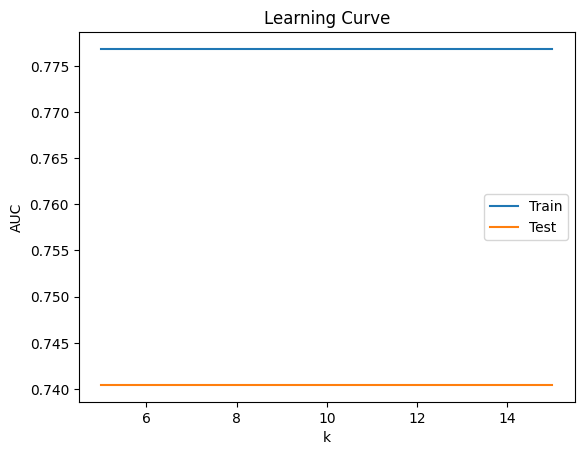

In [ ]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = LogisticRegression()
        model.fit(X_train_over, y_train_over)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train_over)
        train_auc = roc_auc_score(y_train_over, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_val_scaled)
        test_auc = roc_auc_score(y_val, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('k')
    plt.ylabel('AUC')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

param_values = [float(x) for x in np.linspace(5, 15, 10)]
draw_learning_curve(param_values)

In [ ]:
# Untuk Logistic Regression yang sudah dibuat
check_model_fit(
    classifier_logreg,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Logistic Regression"
)


Model Fit Analysis for Logistic Regression:
      Metric  Training  Validation  Difference
0   Accuracy    0.7084      0.6971      0.0113
1  Precision    0.7049      0.1607      0.5442
2     Recall    0.7170      0.6545      0.0625
3         F1    0.7109      0.2580      0.4529
4         F2    0.7145      0.4053      0.3092
5    ROC AUC    0.7779      0.7402      0.0378

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.0378
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


Menggunakan Algorithma Logistic Regression ini di dapatkan model yang sedikit overfitting namun dengan selisih ROC AUC sebesar 0.0364. Waktu melakukan running selama 1m 29.7s.

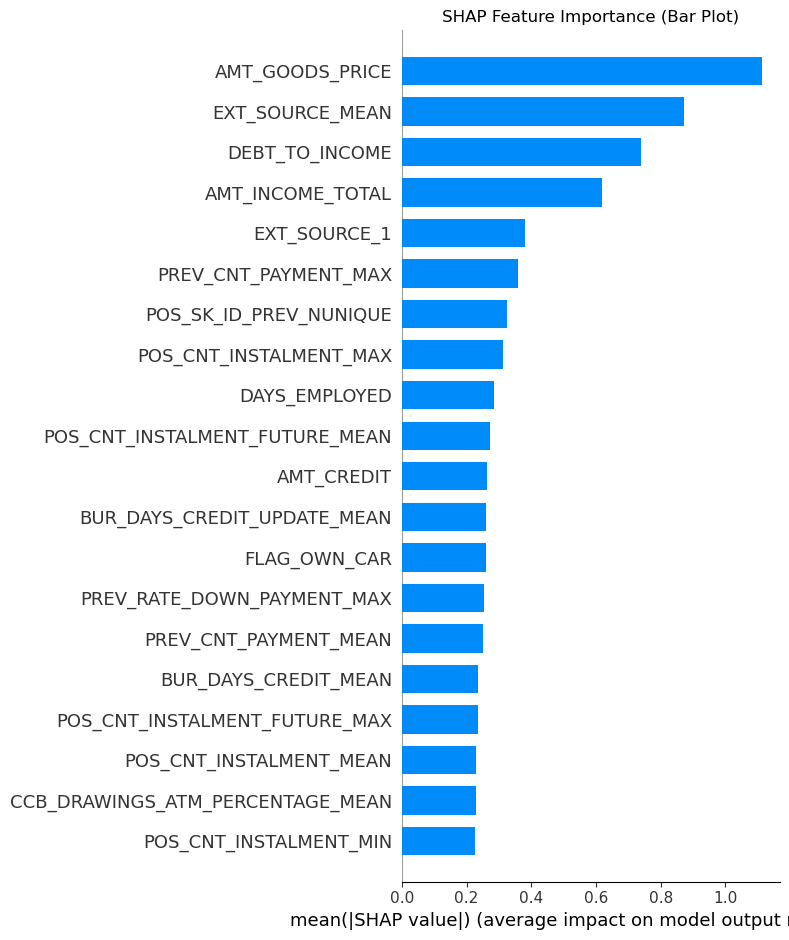

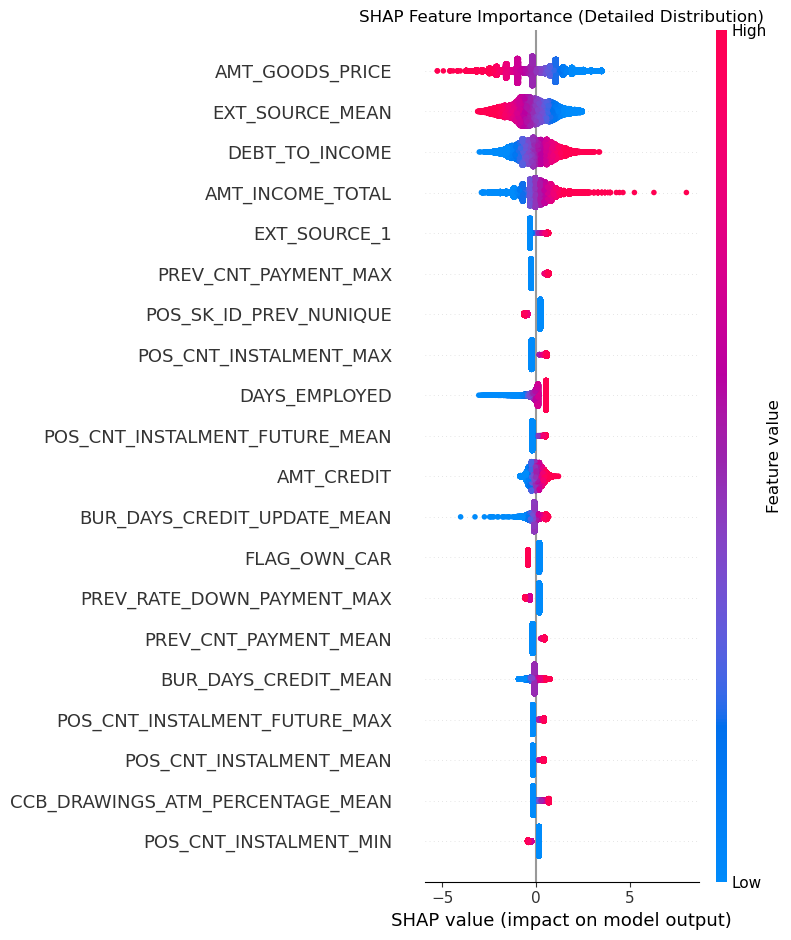

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

explainer = shap.LinearExplainer(classifier_logreg, X_train_over)  # LinearExplainer dengan masker X_train_over
shap_values = explainer.shap_values(X_val_scaled)  # Hitung SHAP values untuk data validasi (X_val_scaled)

# Visualisasi SHAP
# 1. Bar Plot untuk ranking fitur
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()
plt.show()

# 2. Summary Plot untuk distribusi SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_scaled, show=False)
plt.title("SHAP Feature Importance (Detailed Distribution)")
plt.tight_layout()
plt.show()

# Decision Tree

In [ ]:
classifier_dt = DecisionTreeClassifier()
classifier_dt.fit(X_train_over, y_train_over)
y_pred = classifier_dt.predict(X_val_scaled)
y_pred_proba = classifier_dt.predict_proba(X_val_scaled)

# Evaluasi
results_dt = model_evaluation(y_val, y_pred, y_pred_proba, "Decision Tree")
results_dt

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Decision Tree,0.304782,0.081268,0.741362,0.146479,0.282478,0.503969


In [ ]:
#classifier_dt = DecisionTreeClassifier()
#classifier_dt.fit(X_train_over, y_train_over)
check_model_fit(
    classifier_dt,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Decision Tree"
)


Model Fit Analysis for Decision Tree:
      Metric  Training  Validation  Difference
0   Accuracy       1.0      0.3048      0.6952
1  Precision       1.0      0.0813      0.9187
2     Recall       1.0      0.7414      0.2586
3         F1       1.0      0.1465      0.8535
4         F2       1.0      0.2825      0.7175
5    ROC AUC       1.0      0.5040      0.4960

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.4960
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


Decision Tree tampak sangat overfitting dan belum dilakukan hypeparameter tuning karena komputer tidak mampu (meminta restart kernell). Waktu running Decision Tree selama 1m 31.1s.

# Random Forest

In [ ]:
classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train_over, y_train_over)
y_pred = classifier_rf.predict(X_val_scaled)
y_pred_proba = classifier_rf.predict_proba(X_val_scaled)

# Evaluasi
results_rf = model_evaluation(y_val, y_pred, y_pred_proba, "Random Forest")
results_rf

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Random Forest,0.459864,0.109786,0.803597,0.19318,0.354956,0.678011


In [ ]:
check_model_fit(
    classifier_rf,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Random Forest"
)


Model Fit Analysis for Random Forest:
      Metric  Training  Validation  Difference
0   Accuracy       1.0      0.4599      0.5401
1  Precision       1.0      0.1098      0.8902
2     Recall       1.0      0.8036      0.1964
3         F1       1.0      0.1932      0.8068
4         F2       1.0      0.3550      0.6450
5    ROC AUC       1.0      0.6780      0.3220

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.3220
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


Random Forest tampak overfitting meskipun selisih antara ROC AUC tidak sejauh Decision Tree. Waktu running model selama 5m 35.3s.

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters:
{'random_state': 42, 'n_estimators': 166, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 74, 'class_weight': 'balanced'}

Best cross-validation ROC-AUC score:
0.9882647254565244

Validation set ROC-AUC score: 0.6933071486248535

Top 5 parameter combinations:
                                               params  mean_test_score  \
3   {'random_state': 42, 'n_estimators': 166, 'min...         0.988265   
17  {'random_state': 42, 'n_estimators': 157, 'min...         0.987752   
28  {'random_state': 42, 'n_estimators': 181, 'min...         0.987089   
1   {'random_state': 42, 'n_estimators': 65, 'min_...         0.986903   
23  {'random_state': 42, 'n_estimators': 138, 'min...         0.986806   

    std_test_score  rank_test_score  
3         0.020047                1  
17        0.022371                2  
28        0.023381                3  
1         0.023474         

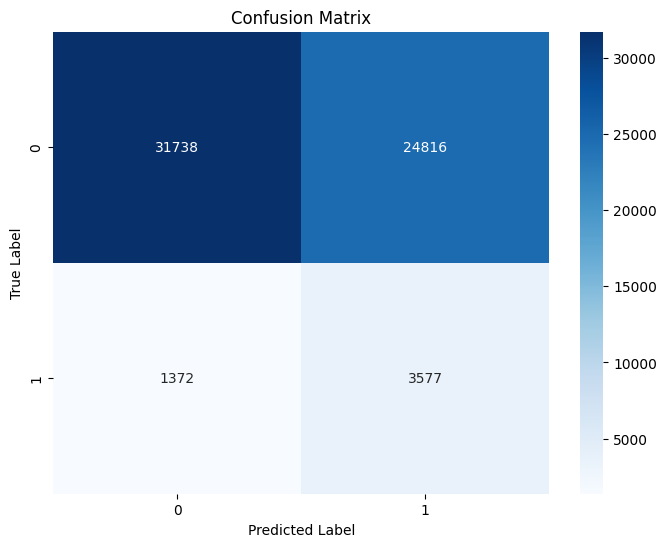

In [ ]:
# 1. Define parameter distributions
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(50, 200, 50)],           # Jumlah trees
    'max_depth': [int(x) for x in np.linspace(2, 100, 50)],           # Kedalaman tree
    'min_samples_split': [int(x) for x in np.linspace(2, 10, 10)],           # Minimum sampel untuk split
    'min_samples_leaf': [int(x) for x in np.linspace(2, 10, 10)],             # Minimum sampel di leaf
    'max_features': ['sqrt', 'log2'],          # Jumlah fitur untuk split
    'class_weight': ['balanced', 'balanced_subsample'],  # Untuk imbalanced data
    'random_state': [42]
}

# 2. Buat base model
base_model = RandomForestClassifier()

# 3. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,                    # Jumlah kombinasi yang dicoba
    scoring='roc_auc',   # Metrik untuk imbalanced data
    cv=5,
    n_jobs=-1,                    # Gunakan semua CPU
    verbose=2,                    # Tampilkan progress
    random_state=42
)

# 4. Fit model
random_search.fit(X_train_over, y_train_over)

# 5. Print parameter terbaik
print("\nBest parameters:")
print(random_search.best_params_)

# 6. Print score terbaik dari cross-validation
print("\nBest cross-validation ROC-AUC score:")
print(random_search.best_score_)

# 7. Evaluasi model dengan parameter terbaik pada validation set
best_model = random_search.best_estimator_
val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
val_score = roc_auc_score(y_val, val_pred_proba)
print("\nValidation set ROC-AUC score:", val_score)

# 8. Lihat performa semua kombinasi parameter
results_df = pd.DataFrame(random_search.cv_results_)
important_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[important_cols].sort_values('rank_test_score')
print("\nTop 5 parameter combinations:")
print(results_df.head())

# 9. Gunakan model terbaik untuk prediksi final
final_predictions = best_model.predict_proba(X_val_scaled)[:, 1]

# 6. Evaluasi model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi
y_pred = random_search.predict(X_val_scaled)
y_pred_proba = random_search.predict_proba(X_val_scaled)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Untuk Logistic Regression yang sudah dibuat
check_model_fit(
    best_model,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Random Forest"
)


Model Fit Analysis for Random Forest:
      Metric  Training  Validation  Difference
0   Accuracy    0.9939      0.5742      0.4197
1  Precision    0.9982      0.1260      0.8722
2     Recall    0.9895      0.7228      0.2667
3         F1    0.9938      0.2146      0.7793
4         F2    0.9912      0.3711      0.6201
5    ROC AUC    0.9999      0.6933      0.3066

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.3066
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


Menggunakan hyperparameter tuning, model mengalami sedikit peningkatan namun masih overfitting. Waktu melakukan parameter tuning adalah 97m 36.7s

# Ada Boost

In [ ]:
classifier_ab = AdaBoostClassifier()
classifier_ab.fit(X_train_over, y_train_over)
y_pred = classifier_ab.predict(X_val_scaled)
y_pred_proba = classifier_ab.predict_proba(X_val_scaled)

# Evaluasi
results_ab = model_evaluation(y_val, y_pred, y_pred_proba, "Ada Boost")
results_ab

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Ada Boost,0.127392,0.083135,0.981612,0.153288,0.310491,0.618448


In [ ]:
check_model_fit(
    classifier_ab,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "Ada Boost"
)


Model Fit Analysis for Ada Boost:
      Metric  Training  Validation  Difference
0   Accuracy    0.8896      0.1274      0.7622
1  Precision    0.8989      0.0831      0.8158
2     Recall    0.8779      0.9816     -0.1037
3         F1    0.8883      0.1533      0.7350
4         F2    0.8820      0.3105      0.5716
5    ROC AUC    0.9531      0.6184      0.3346

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.3346
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


In [ ]:
# Hyperparameter Tuning
# 1. Define parameter grid
# Percobaan ketiga
param_distributions = {
    # Parameter untuk AdaBoost
    'n_estimators': [50, 100, 150, 200],  # Semakin tinggi membuat performa semakin bagus tapi beresiko overfitting
    'learning_rate': [0.01, 0.1, 0.4, 0.5, 0.6],  # Semakin kecil semakin robust tapi butuh lebih banyak estimator
    'algorithm': ['SAMME', 'SAMME.R'],  # Algoritma boosting
    'random_state': [42]
}

# 2. Buat base model
base_model = AdaBoostClassifier()

# 3. Setup GridSearchCV
randomized_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    scoring='roc_auc',        # Optimize berdasarkan ROC-AUC
    cv=5,                     # 5-fold cross validation
    n_jobs=-1,               # Gunakan semua CPU cores
    verbose=2,
)

# 4. Fit model dengan data training
randomized_search.fit(X_train_over, y_train_over)

# 5. Print parameter terbaik
print("\nBest parameters:")
print(randomized_search.best_params_)

# 6. Print score terbaik dari cross-validation
print("\nBest cross-validation ROC-AUC score:")
print(randomized_search.best_score_)

# 7. Evaluasi model dengan parameter terbaik pada validation set
best_model = randomized_search.best_estimator_
val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
val_score = roc_auc_score(y_val, val_pred_proba)
print("\nValidation set ROC-AUC score:", val_score)

# 8. Lihat performa semua kombinasi parameter
results_df = pd.DataFrame(randomized_search.cv_results_)
important_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[important_cols].sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
print(results_df.head())

# 9. Gunakan model terbaik untuk prediksi final
final_predictions = best_model.predict_proba(X_val_scaled)[:, 1]

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters:
{'random_state': 42, 'n_estimators': 100, 'learning_rate': 0.6, 'algorithm': 'SAMME.R'}

Best cross-validation ROC-AUC score:
0.9569119716719324

Validation set ROC-AUC score: 0.6296002655312072

Top 5 parameter combinations:
                                              params  mean_test_score  \
2  {'random_state': 42, 'n_estimators': 100, 'lea...         0.956912   
6  {'random_state': 42, 'n_estimators': 100, 'lea...         0.954461   
3  {'random_state': 42, 'n_estimators': 150, 'lea...         0.940787   
0  {'random_state': 42, 'n_estimators': 100, 'lea...         0.929441   
8  {'random_state': 42, 'n_estimators': 100, 'lea...         0.921593   

   std_test_score  rank_test_score  
2        0.059095                1  
6        0.056184                2  
3        0.053289                3  
0        0.049557                4  
8        0.048488                5  


# XGBoost

In [ ]:
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train_over, y_train_over)
y_pred = classifier_xgb.predict(X_val_scaled)
y_pred_proba = classifier_xgb.predict_proba(X_val_scaled)

# Evaluasi
results_xgb = model_evaluation(y_val, y_pred, y_pred_proba, "Random Forest")
results_xgb

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Random Forest,0.23407,0.089359,0.926854,0.163004,0.322447,0.607066


In [ ]:
check_model_fit(
    classifier_xgb,
    X_train_over,  # Data training
    X_val_scaled,   # Data validation
    y_train_over,  # Label training
    y_val,   # Label validation
    "XGBoost"
)


Model Fit Analysis for XGBoost:
      Metric  Training  Validation  Difference
0   Accuracy    0.9578      0.2341      0.7238
1  Precision    0.9970      0.0894      0.9076
2     Recall    0.9185      0.9269     -0.0084
3         F1    0.9561      0.1630      0.7931
4         F2    0.9332      0.3224      0.6107
5    ROC AUC    0.9860      0.6071      0.3790

Analisis:
⚠️ Model menunjukkan tanda OVERFITTING
    selisih metrics training-validation: 0.3790
   - Model terlalu 'menghapal' data training
   - Performa di validation jauh lebih rendah


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters:
{'subsample': 0.85, 'scale_pos_weight': 4, 'reg_lambda': 0.3, 'reg_alpha': 0, 'random_state': 42, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.75}

Best cross-validation ROC-AUC score:
0.9648982279894772

Validation set ROC-AUC score: 0.6905580179134954


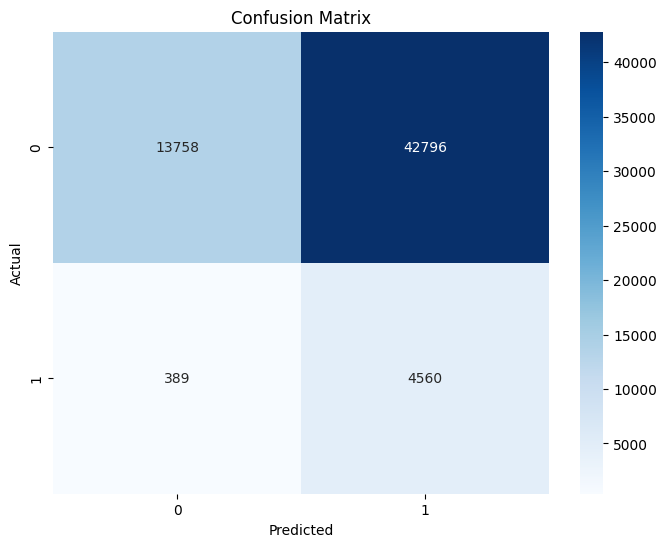


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.24      0.39     56554
           1       0.10      0.92      0.17      4949

    accuracy                           0.30     61503
   macro avg       0.53      0.58      0.28     61503
weighted avg       0.90      0.30      0.37     61503



In [ ]:
# 1. Define parameter grid for hyperparameter tuning
param_distributions = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.02, 0.05],
    'min_child_weight': [3, 5],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'subsample': [0.75, 0.85, 0.95],
    'colsample_bytree': [0.75, 0.85, 0.9],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0, 0.1, 0.3],
    'scale_pos_weight': [4, 5, 6],
    'random_state': [42]
}

# 2. Create base model
base_model = XGBClassifier()

# 3. Setup RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    scoring='roc_auc',      
    cv=3,                   
    n_jobs=-1,             
    verbose=1
)

# 4. Fit model dengan data training
randomized_search.fit(X_train_over, y_train_over)

# 5. Print parameter terbaik
print("\nBest parameters:")
print(randomized_search.best_params_)

# 6. Print score terbaik dari cross-validation
print("\nBest cross-validation ROC-AUC score:")
print(randomized_search.best_score_)

# 7. Evaluasi model dengan parameter terbaik pada validation set
best_model = randomized_search.best_estimator_
val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
val_score = roc_auc_score(y_val, val_pred_proba)
print("\nValidation set ROC-AUC score:", val_score)

# 9. Menghitung dan Menampilkan Confusion Matrix
y_val_pred = best_model.predict(X_val_scaled)

cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 11. Print Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
